# Assign 1 - Deep Learning
Jonathan Menahem - 203772611 <br>
Alon Mazri - 

Help Source: [https://www.analyticsvidhya.com/blog/2020/09/pneumonia-detection-using-cnn-with-implementation-in-python/](https://www.analyticsvidhya.com/blog/2020/09/pneumonia-detection-using-cnn-with-implementation-in-python/)

In [1]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras import layers
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten

In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Exploring The Data

In [3]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras import layers
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten


In [4]:
# Identify Image Resolutions

# Import Packages
import pandas as pd
import matplotlib.pyplot  as plt
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np

# Get the Image Resolutions
root_path = 'chest_xray\\train\\NORMAL\\'
imgs = [img.name for img in Path(root_path).iterdir() if img.suffix == ".jpeg"]
img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get(root_path+f)

# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head()

Total Nr of Images in the dataset: 1349


,FileName,Size,Width,Height,Aspect Ratio
0,IM-0115-0001.jpeg,"(2090, 1858)",2090,1858,1.12
1,IM-0117-0001.jpeg,"(1422, 1152)",1422,1152,1.23
2,IM-0119-0001.jpeg,"(1810, 1434)",1810,1434,1.26
3,IM-0122-0001.jpeg,"(1618, 1279)",1618,1279,1.27
4,IM-0125-0001.jpeg,"(1600, 1125)",1600,1125,1.42


Text(0, 0.5, 'Height')

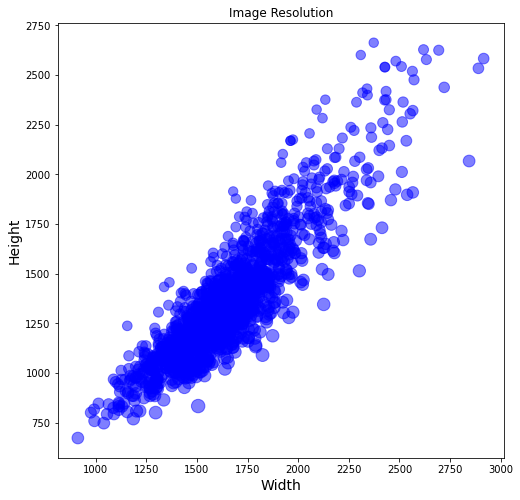

In [5]:
# Visualize Image Resolutions

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

<h2>Loading The Data</h2>

In [6]:
# importing the data into variables

def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))

    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(200,200), interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels

def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(200,200), interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels 

In [7]:
norm_images, norm_labels = load_normal("chest_xray\\train\\NORMAL\\")
pneu_images, pneu_labels = load_pneumonia("chest_xray\\train\\PNEUMONIA\\")

100%|██████████| 3883/3883 [00:32<00:00, 119.81it/s]


In [8]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)

In [9]:
np.unique(y_train, return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2538, 1349, 1345], dtype=int64))

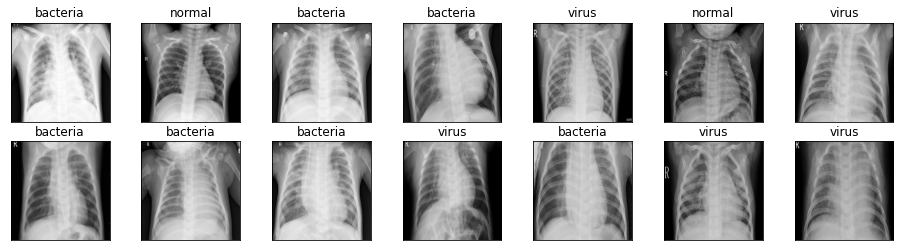

In [10]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [11]:
norm_images_test, norm_labels_test = load_normal("chest_xray\\test\\NORMAL\\")
pneu_images_test, pneu_labels_test = load_pneumonia("chest_xray\\test\\PNEUMONIA\\")
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

100%|██████████| 390/390 [00:02<00:00, 137.64it/s]


In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [13]:
#testing the new shape of our data:

print(X_train.shape)
print(X_test.shape)

(5232, 200, 200, 1)
(624, 200, 200, 1)


<h2>Building The Model</h2>

In [14]:
print(y_train)

['normal' 'normal' 'normal' ... 'bacteria' 'bacteria' 'bacteria']


In [15]:
num_classes = 3
input_shape = (200, 200, 1)

# Scale images to the [0, 1] range
X_train_normalized = X_train.astype("float32") / 255
X_test_normalized = X_test.astype("float32") / 255
# Make sure images have shape (200, 200, 1)
print(X_train_normalized.shape)
print(X_train_normalized.shape[0], "train samples")
print(X_test_normalized.shape[0], "test samples")

le = LabelEncoder()
le.fit(y_train)
y_train_le = le.transform(y_train)
le.fit(y_test)
y_test_le = le.transform(y_test)

# convert class vectors to binary class matrices
y_train_oh = keras.utils.to_categorical(y_train_le, num_classes)
y_test_oh = keras.utils.to_categorical(y_test_le, num_classes)

(5232, 200, 200, 1)
5232 train samples
624 test samples


In [16]:
print(y_train)
print(y_train_le)
print(y_train_oh)

['normal' 'normal' 'normal' ... 'bacteria' 'bacteria' 'bacteria']
[1 1 1 ... 0 0 0]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


# Saving the imported data using pickle module

In [17]:
import pickle

# Use this to save variables
with open('pneumonia_data.pickle', 'wb') as f:
    pickle.dump((X_train_normalized, X_test_normalized, y_train_oh, y_test_oh, num_classes, input_shape), f)

# Loading the imported data using pickle module

In [1]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras import layers
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten

# Use this to load variables
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train_normalized, X_test_normalized, y_train_oh, y_test_oh, num_classes, input_shape) = pickle.load(f)

# Basic Model (without convolution layers)

In [2]:
basic_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Dense(10, activation="relu"),
        layers.Dense(6, activation="relu"),
        layers.Dense(2, activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.1),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [3]:
basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200, 200, 10)      20        
                                                                 
 dense_1 (Dense)             (None, 200, 200, 6)       66        
                                                                 
 dense_2 (Dense)             (None, 200, 200, 2)       14        
                                                                 
 flatten (Flatten)           (None, 80000)             0         
                                                                 
 dropout (Dropout)           (None, 80000)             0         
                                                                 
 dense_3 (Dense)             (None, 3)                 240003    
                                                                 
Total params: 240,103
Trainable params: 240,103
Non-trai

In [4]:
batch_size = 256
epochs = 40

opt = keras.optimizers.Adam(learning_rate=0.001)

basic_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

basic_history = basic_model.fit(X_train_normalized, y_train_oh, batch_size=batch_size, epochs=epochs, validation_split=0.15)

Epoch 1/40
18/18 [==============================] - 2s 86ms/step - loss: 2.4052 - accuracy: 0.3911 - val_loss: 1.5378 - val_accuracy: 0.0357
Epoch 2/40
18/18 [==============================] - 1s 75ms/step - loss: 1.0640 - accuracy: 0.5525 - val_loss: 1.0540 - val_accuracy: 0.5758
Epoch 3/40
18/18 [==============================] - 1s 74ms/step - loss: 0.9674 - accuracy: 0.5453 - val_loss: 0.9364 - val_accuracy: 0.5745
Epoch 4/40
18/18 [==============================] - 1s 75ms/step - loss: 0.8055 - accuracy: 0.7045 - val_loss: 0.8279 - val_accuracy: 0.6268
Epoch 5/40
18/18 [==============================] - 1s 75ms/step - loss: 0.6976 - accuracy: 0.7302 - val_loss: 0.8253 - val_accuracy: 0.6140
Epoch 6/40
18/18 [==============================] - 1s 75ms/step - loss: 0.6465 - accuracy: 0.7369 - val_loss: 0.7641 - val_accuracy: 0.6535
Epoch 7/40
18/18 [==============================] - 1s 75ms/step - loss: 0.6024 - accuracy: 0.7549 - val_loss: 0.6885 - val_accuracy: 0.6930
Epoch 8/40
18

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


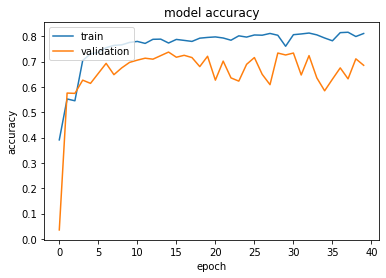

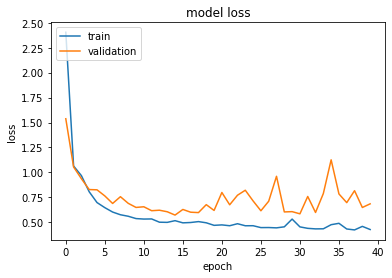

In [5]:
# list all data in history
print(basic_history.history.keys())
# summarize history for accuracy
plt.plot(basic_history.history['accuracy'])
plt.plot(basic_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(basic_history.history['loss'])
plt.plot(basic_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Advanced Model (using convolution layers)

In [6]:
advanced_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", strides=(1, 1), padding='same'),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", strides=(2, 2), padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", strides=(1, 1), padding='same'),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", strides=(1, 1), padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", strides=(1, 1), padding='same'),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", strides=(1, 1), padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.1),
        layers.Dense(100, activation="relu"),
        layers.Dense(50, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
) 

In [7]:
advanced_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 128)      0         
 2D)                                                  

In [8]:
batch_size = 128
epochs = 50

opt = keras.optimizers.Adam(learning_rate=0.001)

advanced_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

advanced_history = advanced_model.fit(X_train_normalized, y_train_oh, batch_size=batch_size, epochs=epochs, validation_split=0.15)

Epoch 1/50
35/35 [==============================] - 7s 105ms/step - loss: 0.8760 - accuracy: 0.5901 - val_loss: 0.9059 - val_accuracy: 0.6038
Epoch 2/50
35/35 [==============================] - 3s 72ms/step - loss: 0.5226 - accuracy: 0.7776 - val_loss: 0.7074 - val_accuracy: 0.6866
Epoch 3/50
35/35 [==============================] - 3s 76ms/step - loss: 0.4522 - accuracy: 0.8019 - val_loss: 0.5927 - val_accuracy: 0.7452
Epoch 4/50
35/35 [==============================] - 3s 73ms/step - loss: 0.4382 - accuracy: 0.8014 - val_loss: 0.5905 - val_accuracy: 0.7465
Epoch 5/50
35/35 [==============================] - 3s 72ms/step - loss: 0.4117 - accuracy: 0.8199 - val_loss: 0.5938 - val_accuracy: 0.7401
Epoch 6/50
35/35 [==============================] - 3s 74ms/step - loss: 0.3834 - accuracy: 0.8271 - val_loss: 0.6296 - val_accuracy: 0.7401
Epoch 7/50
35/35 [==============================] - 2s 71ms/step - loss: 0.3809 - accuracy: 0.8264 - val_loss: 0.6770 - val_accuracy: 0.7210
Epoch 8/50
3

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


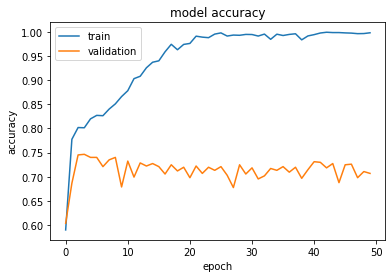

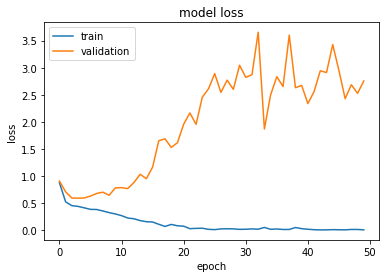

In [9]:
# list all data in history
print(advanced_history.history.keys())
# summarize history for accuracy
plt.plot(advanced_history.history['accuracy'])
plt.plot(advanced_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(advanced_history.history['loss'])
plt.plot(advanced_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()